<a href="https://colab.research.google.com/github/lrssv/ComputacaoEvolutiva/blob/Part-2/Evaluation_EA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pandas import read_csv 
from sklearn.metrics import mean_squared_error
from math import sqrt
import math
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
from matplotlib.pyplot import figure

In [2]:
# Initial population with 100 individuals
tau = 0.5
loops = 100
tours = 200
indiv_size = 19
population_size = 50
models = [DecisionTreeClassifier(max_depth=10),DecisionTreeClassifier(max_depth=3),DecisionTreeClassifier(max_depth=14),
          RandomForestClassifier(max_depth=10),RandomForestClassifier(max_depth=14)]

## Scripts

In [3]:
def database(url):
  df_encoded = pd.read_csv(url)
  df_encoded = df_encoded.drop(columns=['Unnamed: 0'])

  return df_encoded

In [4]:
def train_and_test(df):
  x = df[df.columns.difference(['Victim Sex'])]
  y = df[['Victim Sex']]
  
  x_train, x_test, y_train, y_test = np.array(train_test_split(x, y, test_size=0.2, stratify=y, random_state=42))

  x_train = np.array(x_train)
  x_test = np.array(x_test)
  y_train = np.ravel(y_train)
  y_test = np.array(y_test)

  return (x_train,x_test,y_train,y_test)

In [5]:
def generation_fits(children_fitness):  
  scores = np.array([i[0] for i in children_fitness])
  fitness = []
  
  for i in scores:
    a = tuple(i)
    fitness.append(a)
  
  return fitness

In [6]:
def dominates(obj1, obj2, sign=[-1, -1]):
    indicator = False
    for a, b, sign in zip(obj1, obj2, sign):
        if a * sign > b * sign:
            indicator = True
        # if one of the objectives is dominated, then return False
        elif a * sign < b * sign:
            return False
    return indicator

In [7]:
def sortNondominated(fitness, k=None, first_front_only=False):

    if k is None:
        k = len(fitness)

    map_fit_ind = defaultdict(list)
    for i, f_value in enumerate(fitness):  
        map_fit_ind[f_value].append(i)
    fits = list(map_fit_ind.keys())  

    current_front = []
    next_front = []
    dominating_fits = defaultdict(int)  
    dominated_fits = defaultdict(list) 

    # Rank first Pareto front
    for i, fit_i in enumerate(fits):
        for fit_j in fits[i + 1:]:
            if dominates(fit_i, fit_j):
                dominating_fits[fit_j] += 1  
                dominated_fits[fit_i].append(fit_j)  
            elif dominates(fit_j, fit_i):  
                dominating_fits[fit_i] += 1
                dominated_fits[fit_j].append(fit_i)
        if dominating_fits[fit_i] == 0: 
            current_front.append(fit_i)

    fronts = [[]]  # The first front
    for fit in current_front:
        fronts[-1].extend(map_fit_ind[fit])
    pareto_sorted = len(fronts[-1])

    # Rank the next front until all individuals are sorted or
    if not first_front_only:  # first front only
        N = min(len(fitness), k)
        while pareto_sorted < N:
            fronts.append([])
            for fit_p in current_front:
                for fit_d in dominated_fits[fit_p]: 
                    dominating_fits[fit_d] -= 1  
                    if dominating_fits[fit_d] == 0:  
                        next_front.append(fit_d)
                        pareto_sorted += len(map_fit_ind[fit_d]) 
                        fronts[-1].extend(map_fit_ind[fit_d])
            current_front = next_front
            next_front = []

    return fronts

In [13]:
def myfitness(result_50,models,x_train,x_test,y_train,y_test):
  fit_value = []
  result = []

  for p in result_50:
    model = models[p[0]]
    ind = [i==1 for i in p[2:]] 
    model.fit(x_train[:,ind],y_train)
    y_pred = model.predict(x_test[:,ind])
    rmse = sqrt(mean_squared_error(y_test, y_pred)) 
    fit_value.append(rmse)
    fit_value.append(np.sum(p[2:]))

    result.append([fit_value,p])
    fit_value = []

  return result

In [9]:
def evaluation(genetic_alg,models,x_train,x_test,y_train,y_test):
  indiv = genetic_alg[0]
  best_acc = genetic_alg[0][0]

  model = models[indiv[1][0]]
  ind = [i==1 for i in indiv[1][2:]] 
  model.fit(x_train[:,ind],y_train)
  y_pred = model.predict(x_test[:,ind])
  accuracy = accuracy_score(y_test,y_pred)
  
  print('--------------- RESULTADOS --------------- ')
  print('Melhor individuo: {} \nFitness: {} \nAcurácia: {}'.format(indiv[1],best_acc,accuracy))

In [10]:
def identify_pareto(scores):
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' point is dominated by out 'j' point
            if all(scores[j] <= scores[i]) and any(scores[j] < scores[i]):
              # j dominates i. Label 'i' point as not on Pareto front
              pareto_front[i] = 0
              # Stop further comparisons with 'i' (no more comparisons needed)
              break

    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]

In [11]:
# Original Data
df = database('/content/drive/My Drive/Data Files/df_model_per_encoded')

In [12]:
#Train and Test
x_train,x_test,y_train,y_test = train_and_test(df)

## Populaçao inicial

In [105]:
with open("/content/drive/My Drive/Data Files/initial_population.txt", "rb") as fp:   
  population = pickle.load(fp)

In [106]:
result = myfitness(population,models,x_train,x_test,y_train,y_test)

In [107]:
fits = generation_fits(result)

In [108]:
pareto = sortNondominated(fits)

In [148]:
a = np.array(result)
front = a[pareto[0]]

indiv = [p[1] for p in front]
acc = [p[0] for p in front]

print('--------------- RESULTADOS --------------- ')
p = 0
for i in indiv:
  obj = acc[p] 
  model = models[indiv[1][0]]
  ind = [i==1 for i in indiv[1][2:]] 
  model.fit(x_train[:,ind],y_train)
  y_pred = model.predict(x_test[:,ind])
  accuracy = accuracy_score(y_test,y_pred)
  p += 1
    
  print('Individuo: {} \n Objetivos: {} \nAcurácia: {}'.format(i,obj,accuracy))

--------------- RESULTADOS --------------- 
Individuo: [4, [0.10270215028581048, 0.5322054116627972], False, False, False, True, False, False, True, False, False, False, True, False, False, False, True, False, True] 
 Objetivos: [0.3767444668797538, 5] 
Acurácia: 0.8621359375367097
Individuo: [0, [0.3951971267074766, 0.6135041318861733], False, True, True, False, False, True, False, False, False, False, True, False, False, True, False, True, True] 
 Objetivos: [0.37163781755812386, 7] 
Acurácia: 0.862096780509198
Individuo: [0, [0.005493292022110352, 0.5406499434736692], True, False, True, False, False, False, False, False, False, True, True, False, False, False, True, True, False] 
 Objetivos: [0.3726584411670999, 6] 
Acurácia: 0.8621281061312074
Individuo: [0, [0.08380602154879474, 0.9743908668885592], True, False, False, True, True, True, True, True, True, False, True, True, False, True, False, True, False] 
 Objetivos: [0.36989523588643086, 11] 
Acurácia: 0.8621281061312074
Individ

In [109]:
scores = np.array([i[0] for i in result])

In [110]:
front = scores[pareto[0]]

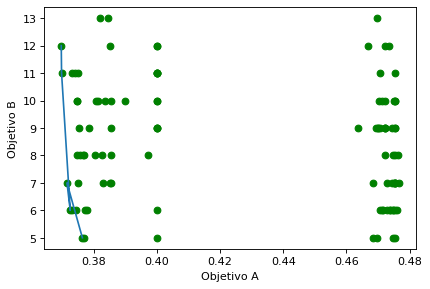

In [20]:
figure(num=None, figsize=(6, 4), dpi=80)

x_all = scores[:, 0]
y_all = scores[:, 1]
plt.scatter(x_all, y_all, color='g')
plt.xlabel('Objetivo A')
plt.ylabel('Objetivo B')

front = scores[pareto[0]]
x_pareto = front[:,0]
y_pareto = front[:,1]

plt.plot(x_pareto,y_pareto)

plt.show()

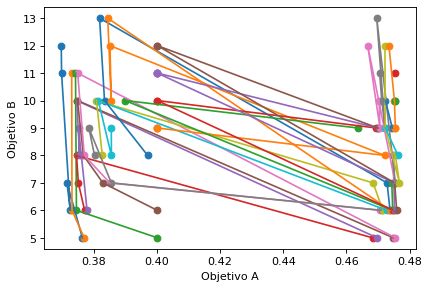

In [21]:
figure(num=None, figsize=(6, 4), dpi=80)

x_all = scores[:, 0]
y_all = scores[:, 1]
plt.xlabel('Objetivo A')
plt.ylabel('Objetivo B')

for i in pareto:
  front = scores[i]
  x_pareto = front[:,0]
  y_pareto = front[:,1]
  plt.scatter(x_pareto, y_pareto)
  plt.plot(x_pareto,y_pareto)

plt.show()

## Resultado com a população de 50 loops

---



### Geração final

In [22]:
with open("/content/drive/My Drive/Data Files/results.txt", "rb") as fp:   
  result_50 = pickle.load(fp)

In [23]:
generation,fronts = result_50

In [24]:
result = fitness(generation,models,x_train,x_test,y_train,y_test)

In [25]:
fits = generation_fits(result)

In [26]:
scores = np.array([i[0] for i in result])

In [27]:
acc = evaluation(result,models,x_train,x_test,y_train,y_test)

--------------- RESULTADOS --------------- 
Melhor individuo: [0 list([0.8218087930813753, 0.8494314266042798]) False False False False
 False True False False False False True False False False False True
 False] 
Fitness: [0.37171156462757754, 3] 
Acurácia: 0.8620654548871886


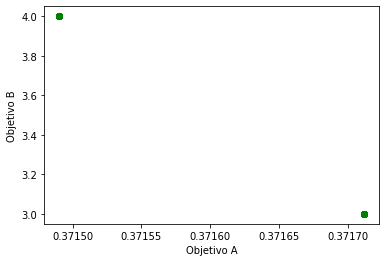

In [28]:
x = scores[:, 0]
y = scores[:, 1]

plt.scatter(x, y, color='g')
plt.xlabel('Objetivo A')
plt.ylabel('Objetivo B')
plt.show()

## Resultado com 100 loops

In [98]:
with open("/content/drive/My Drive/Data Files/results100.txt", "rb") as fp:   
  result_100 = pickle.load(fp)

In [99]:
generation100,fronts100 = result_100

In [100]:
result = fitness(generation100,models,x_train,x_test,y_train,y_test)

In [101]:
fits = generation_fits(result)

In [102]:
scores = np.array([i[0] for i in result])

In [103]:
acc = evaluation(result,models,x_train,x_test,y_train,y_test)

--------------- RESULTADOS --------------- 
Melhor individuo: [0 list([0.8073305956541307, 0.8073508931069016]) False False False True
 False False False False False False True False False False False False
 False] 
Fitness: [0.37557858819193524, 2] 
Acurácia: 0.8591286778238091


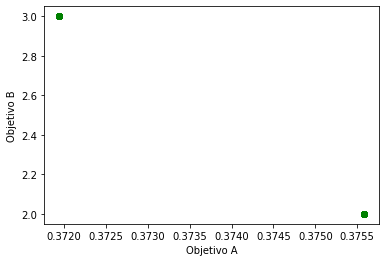

In [104]:
x = scores[:, 0]
y = scores[:, 1]

plt.scatter(x, y, color='g')
plt.xlabel('Objetivo A')
plt.ylabel('Objetivo B')
plt.show()